In [1]:
import pandas as pd
import os
import numpy as np
from scipy.stats import mannwhitneyu
import seaborn as sns
from matplotlib import pyplot as plt
import re
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings('ignore') #supresses warnings for now
#warnings.filterwarnings(action='once') #shows warnings once
from statannotations.Annotator import Annotator


dataFilePath = os.path.join(os.getcwd(),'Data')

kicsSVdf = pd.read_csv(os.path.join(dataFilePath,'kics_structural_variations.txt'), sep = '\t', header = 0)
#kicsTEdf = pd.read_csv(os.path.join(dataFilePath,'kics_transposable_elements.txt'), sep = '\t', header = 0)
lfsSVdf = pd.read_csv(os.path.join(dataFilePath,'lfs_structural_variations.txt'), sep = '\t', header = 0)
#lfsTEdf = pd.read_csv(os.path.join(dataFilePath,'lfs_transposable_elements.txt'), sep = '\t', header = 0)
lfsClinicdf = pd.read_csv(os.path.join(dataFilePath,'lfs_clinical_main.tsv'), sep = '\t', header = 0)
kicsClinicdf = pd.read_csv(os.path.join(dataFilePath,'kics_clinical_edited.csv'), encoding='latin-1')

In [2]:
"""
SV clean up
"""
def maxGDAFFilter(colName: str, df: pd.DataFrame)->pd.DataFrame:
    temp = df[colName].str.contains(pat=',')
    Index = list(np.where(temp == True)[0])
    temp = df[colName].iloc[Index]
    tempIndex = temp.index 
    
    for i in tempIndex:
        tempList = temp[i].split(',')
        tempList = [float(a) for a in tempList]
        maxTemp = max(tempList)
        df[colName][i] = maxTemp

    df[colName] = df[colName].astype('float64')
    
    return df
    
kicsSVdf = maxGDAFFilter('GD_AF', kicsSVdf)
lfsSVdf = maxGDAFFilter('GD_AF', lfsSVdf)

listValSearch = ['291775', '298313', '315666', '320118', '18_1907']
# searched for kID of 63, 83, 156, 171, 219
# kID 120 141 and 232 do not have any matches...
#what would make this that much better is if it was a dict. Computationally less heavy?

for i in listValSearch: 
    kicsSVdf.drop(kicsSVdf[kicsSVdf['sample_id'].str.contains(i)==True].index, inplace = True)

In [3]:
"""
full filter and rare
"""

kicsSVdf = kicsSVdf.loc[(kicsSVdf['AnnotSV type'] == 'full') & (kicsSVdf['GD_AF'] < 0.01)]
lfsSVdf = lfsSVdf.loc[(lfsSVdf['AnnotSV type'] == 'full') & (lfsSVdf['GD_AF'] < 0.01)]

kicsSVdf['SV chrom'] = kicsSVdf['SV chrom'].astype(str)
lfsSVdf['SV chrom'] = lfsSVdf['SV chrom'].astype(str)

kicsSVdf['sample_id'] = kicsSVdf['sample_id'].astype(str)
lfsSVdf['sample_id'] = lfsSVdf['sample_id'].astype(str)

kicsSVdf['sample_id'] = kicsSVdf['sample_id'].str.replace(" ", "")
lfsSVdf['sample_id'] = lfsSVdf['sample_id'].str.replace(" ", "")

#kicsSVnum = kicsSVF['sample_id'].count()
#lfsSVnum = lfsSVF['sample_id'].count()


In [4]:
"""
Kics clinic df cleaning
"""
#listValSearch = ['291775', '298313', '315666', '320118', '18_1907']
listValSearch = ['63', '83', '156', '171', '219', '120', '141', '232']
# searched for kID of 63, 83, 156, 171, 219
# kID 120 141 and 232 do not have any matches...

kicsClinicdf['KiCS ID'] = kicsClinicdf['KiCS ID'].astype(str)
kicsClinicdf['KiCS ID'] = kicsClinicdf['KiCS ID'].str.replace(" ", "")

for i in listValSearch:
    kicsClinicdf.drop(kicsClinicdf[kicsClinicdf['KiCS ID']==i].index, inplace = True)

#these two lines are causing us to go from 140->90 ish samples    
kicsClinicdf.drop(kicsClinicdf.loc[kicsClinicdf['tissue_type']=='?'].index, inplace=True)
kicsClinicdf.drop(kicsClinicdf.loc[pd.isna(kicsClinicdf['lfs_cancer_type_diagnosis'])].index, inplace=True)


# # intial tissue types and diagnosis types
# kUniqueTissue = kicsClinicdf['tissue_type'].unique()
# kUniqueDiag = kicsClinicdf['lfs_cancer_type_diagnosis'].unique()

# print(kUniqueTissue)
# print(kUniqueDiag)

In [5]:
"""
lfs clinic df cleaning
"""
lfsClinicdf['sample'] = lfsClinicdf['sample'].astype(str)
lfsClinicdf['sample'] = lfsClinicdf['sample'].str.replace(" ", "")

for i in listValSearch:
    lfsClinicdf.drop(lfsClinicdf[lfsClinicdf['sample']==i].index, inplace = True)
    

#print(lfsClinicdf[lfsClinicdf['tissue_type']=='CNS']) #more than 1 patient
    
lfsClinicdf.drop(lfsClinicdf.loc[lfsClinicdf['tissue_type']=='?'].index, inplace=True)
lfsClinicdf.drop(lfsClinicdf.loc[pd.isna(lfsClinicdf['cancer_diagnosis'])].index, inplace=True)


#print(lfsClinicdf[lfsClinicdf['tissue_type']=='CNS']) #more than 1 patient

# lUniqueTissue = lfsClinicdf['tissue_type'].unique()
# lUniqueDiag = lfsClinicdf['cancer_diagnosis'].unique()

# print(lUniqueTissue)
# print(lUniqueDiag)

In [42]:
def BoxGraphMulti(df: pd.DataFrame, xCol, yCol, compCol, orderList):
    plt.rcParams["figure.figsize"] = [15, 10]
    ax = sns.boxplot(data=df, x=xCol, y=yCol, hue=compCol, medianprops={"linewidth": 4, 'color':'black'})
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right")

    
    lfs = df[df[compCol]=='lfs']
    kics = df[df[compCol]=='kics']
    
    excludeList = list(set(lfs[xCol]).symmetric_difference(set(kics[xCol])))

    #add statistical test here
    listPairing = []
    #pairings for multi correction
    for i in orderList:
        #excludeList = ['Unaffeceted', 'Sarcoma', 'Other', 'US', 'Thyroid', 'Ovaries']        
        #tissueDiff = list(set(df['tissue_type']).symmetric_difference(set(df['tissue_type'])))
        #diagDiff = list(set(df['cancer_diagnosis']).symmetric_difference(set(df['lfs_cancer_type_diagnosis'])))
        
        if i not in excludeList:
            p1 = (i, 'kics')
            p2 = (i, 'lfs')
            p = (p1,p2)
            listPairing.append(p)
        
    annot = Annotator(ax, listPairing, data=df, x=xCol, y=yCol, hue=compCol)
    annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
    annot.apply_and_annotate()


    plt.show()

In [48]:
def BarGraphNormalized(label1: str, label2:str, df: pd.DataFrame, col1: str, col2: str,
                        xTitle: str, yTitle: str, divisor1: float, divisor2: float,
                        labels: list):
    #'kics', 'lfs', invdf, 'kchrom', 'lchrom', 'Chromosomes','Frequency','Graph2-INV',kicsSVnum, lfsSVnum

    title = label1 + " " + label2
    count1 = df[col1].value_counts()
    count2 = df[col2].value_counts()
    
    x_axis = np.arange(len(labels))
        
    for i in labels:
        if (not(i in count1)):
            add = pd.Series([0], index=[i])
            count1 = count1.append(add)
        if (not(i in count2)):
            add = pd.Series([0], index=[i])
            count2 = count2.append(add)
            
    plt.bar(x_axis - 0.2, [count1[a]/divisor1 for a in labels], 0.4, label = label1)
    plt.bar(x_axis + 0.2, [count2[a]/divisor2 for a in labels], 0.4, label = label2)

    #plt.tick_params(labelrotation=45, labelright=True)
    #plt.setp(ha="right", rotation=45)
    
    plt.xticks(x_axis, labels, ha='right', rotation = 45)
    plt.xlabel(xTitle)
    plt.ylabel(yTitle)
    plt.title(title)
    plt.legend()
    plt.show()


In [8]:
"""
kics matching between SV and Clinical
"""

def kIdAbbv(clinicDf, svDf, clinicCol, svCol):
    
    clinicDf.drop(clinicDf[clinicDf[clinicCol]=='Not applicable'].index, inplace = True)
    
    svDf[svCol] = svDf[svCol].astype(str)
    clinicDf[clinicCol] = clinicDf[clinicCol].astype(str)
    svDf[svCol] =  svDf[svCol].str.replace(" ", "")
    clinicDf[clinicCol] = clinicDf[clinicCol].str.replace(" ", "")
    
    list1 = svDf[svCol].unique()
    list2 = clinicDf[clinicCol].unique()
    
    svDict = dict()
    clinicDict = dict()
    
    for i in range (len(list1)):
        tempList = re.findall('\d{3,}', list1[i])

        #if empty, take the second one
        if not tempList:
            tempList = re.findall('\d+', list1[i])
            svDict[list1[i]] = tempList[1]

        #if not empty 
        else:
            svDict[list1[i]] = tempList[0]


    for i in range (len(list2)):    
        tempList = re.findall('\d{3,}', list2[i])
    
        #if empty, take the second one
        if not tempList:
            tempList = re.findall('\d+', list2[i])
            clinicDict[list2[i]] = tempList[1]

        #if not empty 
        else:
            clinicDict[list2[i]] = tempList[0]
    

    clinicDf['abbv_id'] = clinicDf[clinicCol].map(clinicDict)
    svDf['abbv_id'] = svDf[svCol].map(svDict)
    
    print(len(svDf[svCol].unique()))
#     print(svDf[svCol].unique())
    
    df = pd.merge(svDf[[svCol,'SV type','abbv_id']],                   
                     clinicDf[[clinicCol, 'tumour_class','tissue_type','lfs_cancer_type_diagnosis', 'abbv_id']],
                     left_on = 'abbv_id', 
                     right_on = 'abbv_id', 
                     how='inner')

    return df

In [9]:
bigKDf = kIdAbbv(kicsClinicdf, kicsSVdf, 'CCP germline', 'sample_id',)
print(len(bigKDf['abbv_id'].unique()))
# print(bigKDf['sample_id'].unique())
# print(len(kicsSVdf['sample_id'].unique()))
# print(len(kicsClinicdf['CCP germline'].unique()))
#prints out how many we had before the id matching and how many we have left after the id matching

191
93


In [10]:
print(bigKDf)

      sample_id SV type abbv_id CCP germline       tumour_class tissue_type  \
0        313703     DEL  313703       313703         CNS TUMORS         CNS   
1        313703     DEL  313703       313703         CNS TUMORS         CNS   
2        313703     DUP  313703       313703         CNS TUMORS         CNS   
3        313703     DEL  313703       313703         CNS TUMORS         CNS   
4        313703     DEL  313703       313703         CNS TUMORS         CNS   
...         ...     ...     ...          ...                ...         ...   
16734    292600     DEL  292600       292600  LEUKEMIA/LYMPHOMA       Blood   
16735    292600     DEL  292600       292600  LEUKEMIA/LYMPHOMA       Blood   
16736    292600     INV  292600       292600  LEUKEMIA/LYMPHOMA       Blood   
16737    292600     DEL  292600       292600  LEUKEMIA/LYMPHOMA       Blood   
16738    292600     DEL  292600       292600  LEUKEMIA/LYMPHOMA       Blood   

      lfs_cancer_type_diagnosis  
0                

In [11]:
"""Filter the ? and the nan"""
#print(bigKDf['tissue_type'].unique())
bigKDf.drop(bigKDf.loc[bigKDf['tissue_type']=='?'].index, inplace=True)

#bigKDfDiag.drop(bigKDf.loc[pd.isna(bigKDf['lfs_cancer_type_diagnosis'])].index, inplace=True)
print(len(bigKDf['abbv_id'].unique()))
#print(kicsClinicdf['tissue_type'].value_counts())

93


In [12]:
lfsSVdf['sample_id'] = lfsSVdf['sample_id'].astype(str)
lfsClinicdf['sample'] = lfsClinicdf['sample'].astype(str)

In [13]:
print(len(lfsSVdf['sample_id'].unique())) #only 65 to begin with D:
print(lfsSVdf['sample_id'].unique())

print(len(lfsClinicdf['sample'].unique()))

65
['4257' 'SJACT008_G' '808' '2085' '1087' '1092' '3805' '3136A' '4033'
 '2447' '353' '3806' '4854' '1478' '2262' '4028' '2957' '3688' '93' '1357'
 '2565' '4329' '4535_S1' '3298A' '2349' '2446' '3473' '5567' '3273' '3885'
 '3432' '1843' '3763' '3503' 'PD13489b' '2463' '2760A' '3643' 'SJACT001_G'
 '4227' '5537' '3367' 'SJACT002_G' '2815' '5536' '3634' '1476'
 'SJACT005_G' '3425' '3365' '2413' 'SJACT007_G' '3356' '3361' '3687_2'
 '3332' '94' '1355' '2784' '2465' '3319' 'PD7195b' '3334' '352' '2765']
460


In [14]:
"""
Can directly map the two
Apply on Filtered Prelim Graphs
"""

bigLDf = pd.merge(lfsSVdf[['sample_id','SV chrom','GD_AF', 'SV type']],
                 lfsClinicdf[['sample','tissue_type','cancer_diagnosis']],
                 left_on = 'sample_id',
                 right_on = 'sample',
                 how='inner')

In [15]:
"""
Difference between the unique tissues and unique diagnosis in kics vs lfs
"""

tissueDiff = list(set(bigLDf['tissue_type']).symmetric_difference(set(bigKDf['tissue_type'])))
diagDiff = list(set(bigLDf['cancer_diagnosis']).symmetric_difference(set(bigKDf['lfs_cancer_type_diagnosis'])))

print(tissueDiff)
print(diagDiff)

['Other', 'Ovaries', 'Unaffected', 'Thyroid']
['AL', 'Undifferentiated sarcoma', 'Other', 'Ovaries', 'AA', 'US', 'Meningioma', 'T-NHL', 'MFS', 'T-LL', 'Thyroid', 'LMS', 'ALL', 'MFH', 'CPC', 'AMKL', 'B-ALL', 'High Grade Sarcoma', 'AML', 'Unaffected', 'CSA', 'MPAL', 'PNET']


In [16]:
"""
Drop the rows that are in the diff
"""

####YOU DROPPED TOO MANY, Don't drop any
#bigLDf.drop(bigLDf[bigLDf['tissue_type'].isin(tissueDiff)].index, inplace = True)
#bigKDf.drop(bigKDf[bigKDf['tissue_type'].isin(tissueDiff)].index, inplace = True)

#bigLDf.drop(bigLDf[bigLDf['cancer_diagnosis'].isin(diagDiff)].index, inplace = True)
#bigKDf.drop(bigKDf[bigKDf['lfs_cancer_type_diagnosis'].isin(diagDiff)].index, inplace = True)

kicsTissue = pd.DataFrame(data = {'tissue_type':bigKDf['tissue_type'], 'id':bigKDf['sample_id']})
kicsT = kicsTissue

lfsTissue = pd.DataFrame(data = {'tissue_type':bigLDf['tissue_type'], 'id':bigLDf['sample']})
lfsT = lfsTissue

groupedTissue = pd.DataFrame(data={'ktissue':kicsTissue['tissue_type'], 'ltissue':lfsTissue['tissue_type']})

lfsDiag = pd.DataFrame(data = {'diag':bigLDf['cancer_diagnosis'], 'id':bigLDf['sample']})
# lfsD = lfsDiag
kicsDiag = pd.DataFrame(data = {'diag':bigKDf['lfs_cancer_type_diagnosis'], 'id':bigKDf['sample_id']})
kicsD = kicsDiag

groupedDiag = pd.DataFrame(data={'kdiag':kicsDiag['diag'],'ldiag': lfsDiag['diag']})

kicsTidList = kicsDiag['id'].unique()
lfsTidList = lfsDiag['id'].unique()
kicsDiagList = list(kicsDiag['diag'].unique())
lfsDiagList = list(lfsDiag['diag'].unique())

kicsIdList = kicsTissue['id'].unique()
kicsTissueList = list(kicsTissue['tissue_type'].unique())
lfsTissueList = list(lfsTissue['tissue_type'].unique())
lfsIdList = lfsTissue['id'].unique()

#print(type(kicsTissueList))

uniqueTissue = list(set(kicsTissueList+lfsTissueList))
uniqueDiag = list(set(kicsDiagList+lfsDiagList))

print(uniqueTissue)
print(uniqueDiag)
#print(kicsTissue['tissue_type'].unique())
#print(lfsTissue['tissue_type'].unique())


['Soft Tissue', 'Other', 'Colon', 'Adrenal', 'Ovaries', 'US', 'Breast', 'Blood', 'Unaffected', 'Thyroid', 'CNS', 'Bone']
['Undifferentiated sarcoma', 'Other', 'ACC', 'Ovaries', 'US', 'T-NHL', 'T-LL', 'ALL', 'LMS', 'MFH', 'B-ALL', 'Breast', 'AML', 'Unaffected', 'CSA', 'PNET', 'Glioma', 'AL', 'AA', 'Meningioma', 'MFS', 'Thyroid', 'RMS', 'CPC', 'Colon', 'High Grade Sarcoma', 'MPAL', 'AMKL', 'OS']


# Diagnosis Type

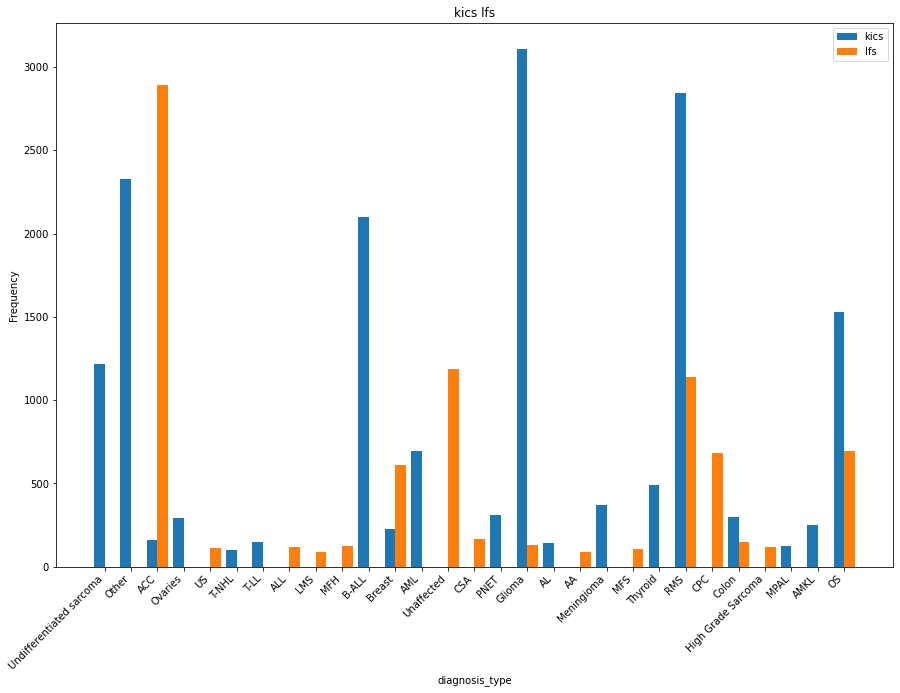

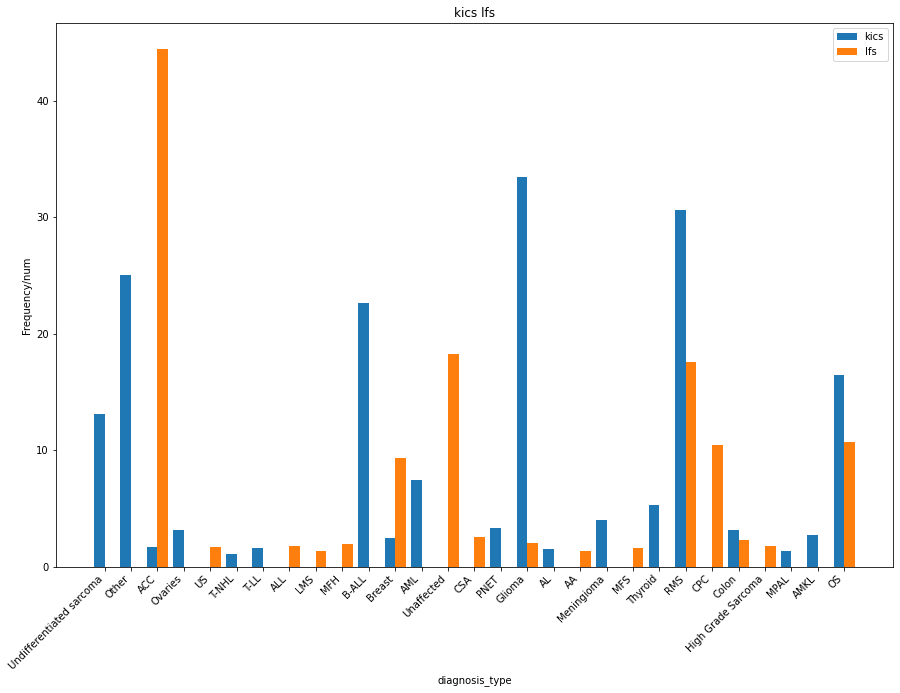

In [49]:
BarGraphNormalized('kics', 'lfs', groupedDiag, 'kdiag', 'ldiag', 'diagnosis_type', 'Frequency', 1.0,1.0, uniqueDiag)
    
BarGraphNormalized('kics', 'lfs', groupedDiag, 'kdiag', 'ldiag', 'diagnosis_type','Frequency/num',
                   len(kicsTidList), len(lfsTidList), uniqueDiag)

# Tissue Type

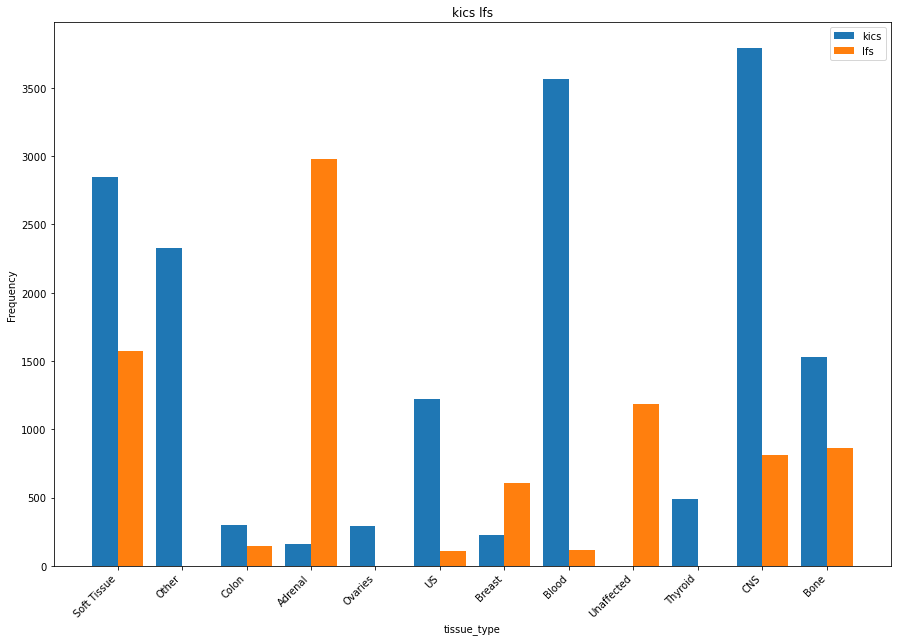

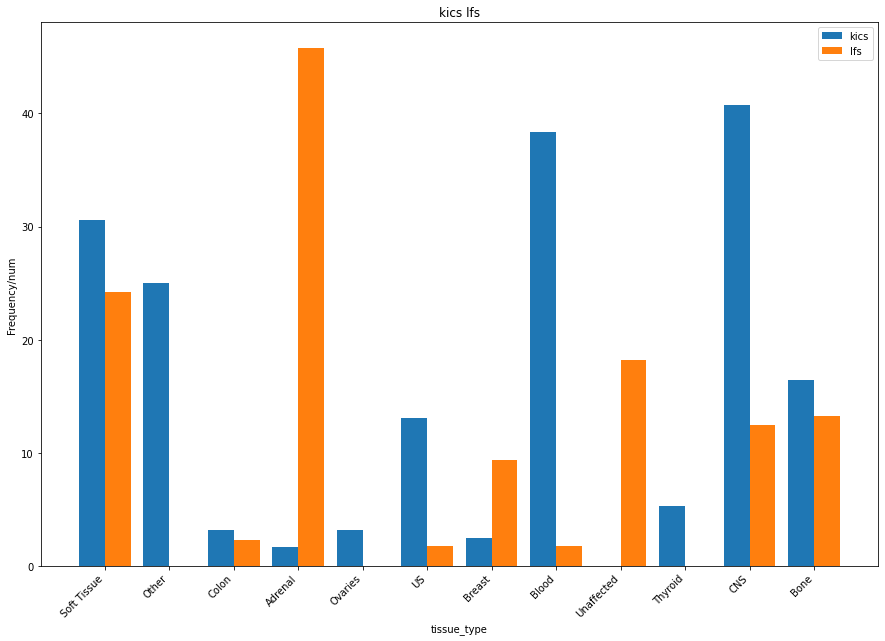

In [50]:
BarGraphNormalized('kics', 'lfs', groupedTissue, 'ktissue', 'ltissue', 'tissue_type','Frequency',
                   1.0,1.0, uniqueTissue)

BarGraphNormalized('kics', 'lfs', groupedTissue, 'ktissue', 'ltissue', 'tissue_type', 'Frequency/num',
                  len(kicsIdList), len(lfsIdList), uniqueTissue)

In [19]:
bigKDf.rename(columns = {'lfs_cancer_type_diagnosis':'cancer_diagnosis'}, inplace = True)

kDel = bigKDf.loc[bigKDf['SV type'] == 'DEL']
kDup = bigKDf.loc[bigKDf['SV type'] == 'DUP']
kInv = bigKDf.loc[bigKDf['SV type'] == 'INV']

lDel = bigLDf.loc[bigLDf['SV type'] == 'DEL']
lDup = bigLDf.loc[bigLDf['SV type'] == 'DUP']
lInv = bigLDf.loc[bigLDf['SV type'] == 'INV']

print(kDel.head(30))
print(lDel.head(30))

   sample_id SV type abbv_id CCP germline tumour_class tissue_type  \
0     313703     DEL  313703       313703   CNS TUMORS         CNS   
1     313703     DEL  313703       313703   CNS TUMORS         CNS   
3     313703     DEL  313703       313703   CNS TUMORS         CNS   
4     313703     DEL  313703       313703   CNS TUMORS         CNS   
5     313703     DEL  313703       313703   CNS TUMORS         CNS   
6     313703     DEL  313703       313703   CNS TUMORS         CNS   
7     313703     DEL  313703       313703   CNS TUMORS         CNS   
8     313703     DEL  313703       313703   CNS TUMORS         CNS   
9     313703     DEL  313703       313703   CNS TUMORS         CNS   
10    313703     DEL  313703       313703   CNS TUMORS         CNS   
11    313703     DEL  313703       313703   CNS TUMORS         CNS   
12    313703     DEL  313703       313703   CNS TUMORS         CNS   
13    313703     DEL  313703       313703   CNS TUMORS         CNS   
14    313703     DEL

In [20]:
def graphSVTissue(kdf, ldf, uniqueList, isTissue):
    if isTissue:
        var = 'tissue_type'

    else:
        var = 'cancer_diagnosis'
    
    kdf = kdf.drop(['sample_id', 'SV type'], axis=1)
    kdf = kdf.groupby(['abbv_id']).value_counts()
    kdf = kdf.to_frame().reset_index()

    kdf.rename(columns = {0:'freq'}, inplace = True)
    kdf = pd.melt(kdf, id_vars=[var], value_vars=['freq'])
    kdf['dataset'] = 'kics'

    ldf = ldf.drop(['SV chrom', 'GD_AF',
                        'SV type'], axis=1)
    ldf = ldf.groupby(['sample_id']).value_counts()
    ldf = ldf.to_frame().reset_index()
    ldf.rename(columns = {0:'freq'}, inplace = True)

    ldf = pd.melt(ldf, id_vars=[var], value_vars=['freq'])
    ldf['dataset'] = 'lfs'

    mergedDf = pd.concat([ldf, kdf])
    print(mergedDf.head(50))
    
    BoxGraphMulti(mergedDf, var, 'value', 'dataset', uniqueList) 

## DEL

['Soft Tissue', 'Other', 'Colon', 'Adrenal', 'Ovaries', 'US', 'Breast', 'Blood', 'Unaffected', 'Thyroid', 'CNS', 'Bone']
    tissue_type variable  value dataset
0       Adrenal     freq     73     lfs
1   Soft Tissue     freq    111     lfs
2   Soft Tissue     freq    118     lfs
3    Unaffected     freq     74     lfs
4           CNS     freq     99     lfs
5    Unaffected     freq    120     lfs
6   Soft Tissue     freq    105     lfs
7   Soft Tissue     freq    120     lfs
8   Soft Tissue     freq    113     lfs
9   Soft Tissue     freq     62     lfs
10      Adrenal     freq    119     lfs
11   Unaffected     freq    101     lfs
12   Unaffected     freq     55     lfs
13  Soft Tissue     freq     76     lfs
14   Unaffected     freq     92     lfs
15   Unaffected     freq     75     lfs
16      Adrenal     freq    161     lfs
17      Adrenal     freq     56     lfs
18          CNS     freq     89     lfs
19   Unaffected     freq    105     lfs
20      Adrenal     freq    116     lfs

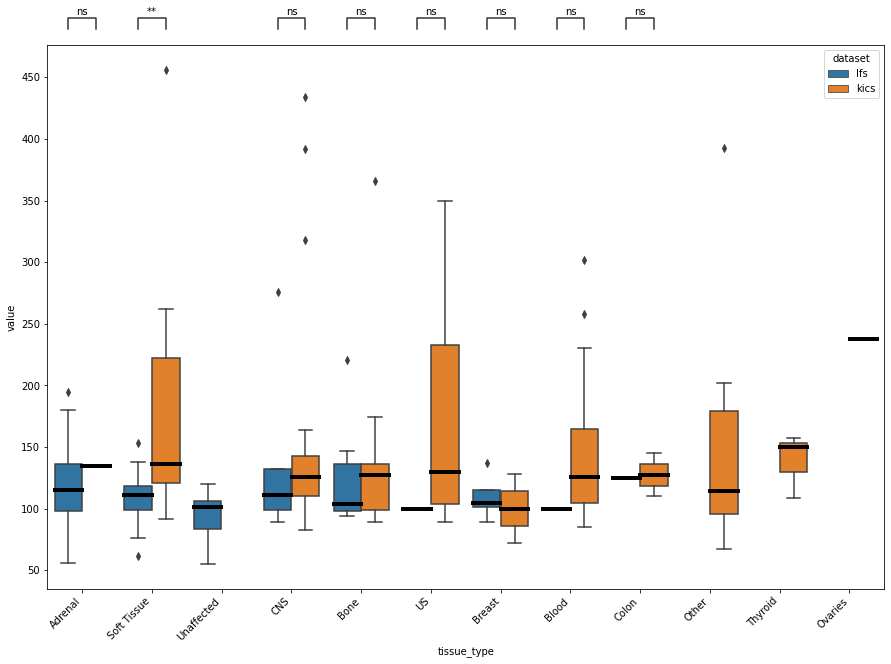

In [43]:
#print(kDel['tissue_type'].unique())
#print(lDel['tissue_type'].unique())
print(uniqueTissue)

graphSVTissue(kDel, lDel, uniqueTissue, True)

# for i in uniqueLabels:
#     print(i)
#     dog = normKdf.loc[normKdf['chrom'] == i]
#     list1 = dog['normalized'].tolist()
#     cat = normLdf.loc[normLdf['chrom'] == i]
#     list2 = cat['normalized'].tolist()
#     print(mannwhitneyu(list1, list2))


      cancer_diagnosis variable  value dataset
0                   AA     freq     73     lfs
1                  MFH     freq    111     lfs
2                  RMS     freq    118     lfs
3           Unaffected     freq     74     lfs
4                  CPC     freq     99     lfs
5           Unaffected     freq    120     lfs
6   High Grade Sarcoma     freq    105     lfs
7                  RMS     freq    120     lfs
8                  RMS     freq    113     lfs
9                  RMS     freq     62     lfs
10                 ACC     freq    119     lfs
11          Unaffected     freq    101     lfs
12          Unaffected     freq     55     lfs
13                 LMS     freq     76     lfs
14          Unaffected     freq     92     lfs
15          Unaffected     freq     75     lfs
16                 ACC     freq    161     lfs
17                 ACC     freq     56     lfs
18                 CPC     freq     89     lfs
19          Unaffected     freq    105     lfs
20           

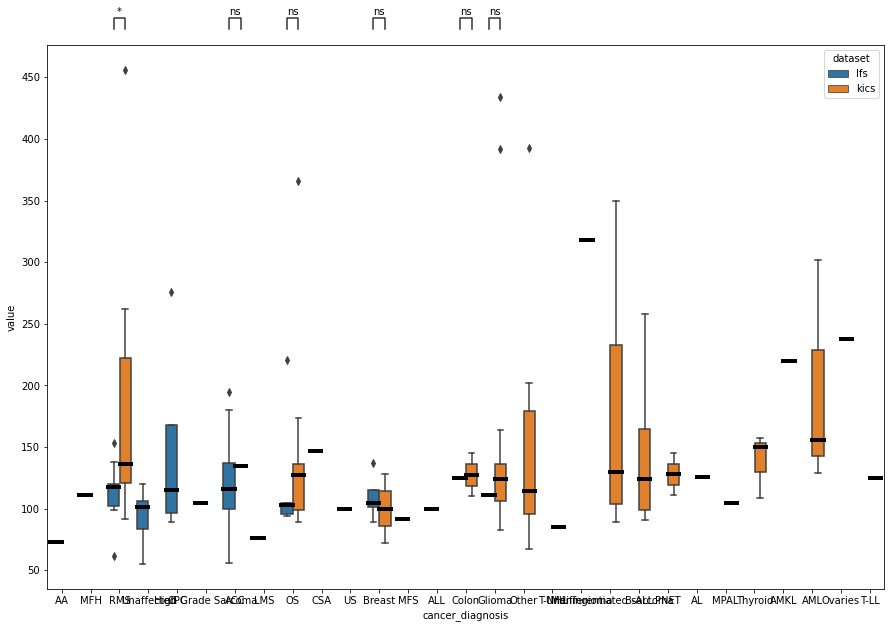

In [33]:
#print(lDel.head(50))

graphSVTissue(kDel, lDel, uniqueDiag, False)


## DUP

['CNS', 'Soft Tissue', 'Blood', 'Bone', 'Other', 'US', 'Thyroid', 'Breast', 'Colon', 'Adrenal', 'Ovaries']
    tissue_type variable  value dataset
0       Adrenal     freq      8     lfs
1   Soft Tissue     freq      8     lfs
2   Soft Tissue     freq      9     lfs
3    Unaffected     freq      7     lfs
4           CNS     freq     10     lfs
5    Unaffected     freq     12     lfs
6   Soft Tissue     freq      6     lfs
7   Soft Tissue     freq      7     lfs
8   Soft Tissue     freq      9     lfs
9   Soft Tissue     freq      8     lfs
10      Adrenal     freq      8     lfs
11   Unaffected     freq     11     lfs
12   Unaffected     freq      5     lfs
13  Soft Tissue     freq      5     lfs
14   Unaffected     freq     16     lfs
15   Unaffected     freq      8     lfs
16      Adrenal     freq      6     lfs
17      Adrenal     freq      4     lfs
18          CNS     freq      4     lfs
19   Unaffected     freq     12     lfs
20      Adrenal     freq     22     lfs
21  Soft Tiss

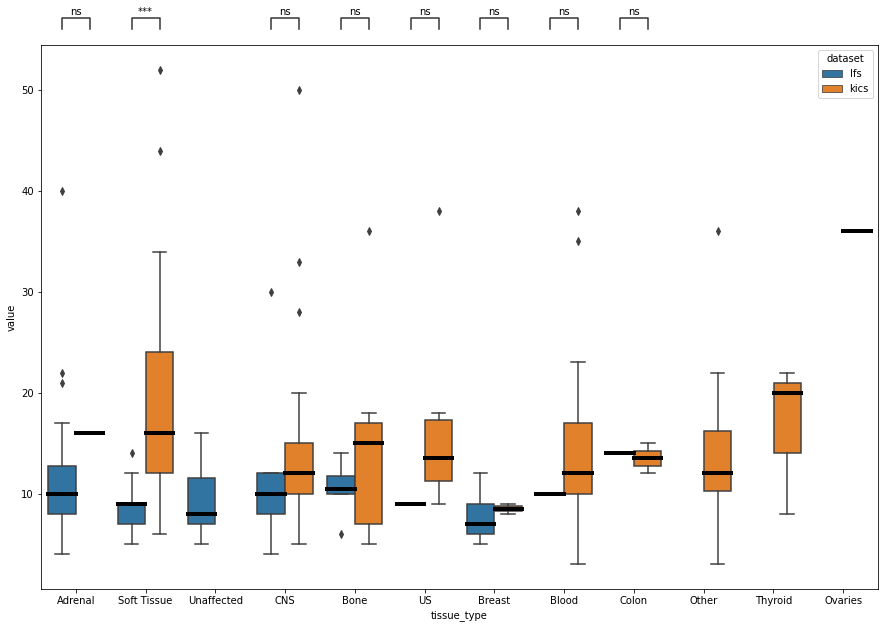

In [34]:
print(kicsTissueList)
graphSVTissue(kDup, lDup, uniqueTissue, True)


      cancer_diagnosis variable  value dataset
0                   AA     freq      8     lfs
1                  MFH     freq      8     lfs
2                  RMS     freq      9     lfs
3           Unaffected     freq      7     lfs
4                  CPC     freq     10     lfs
5           Unaffected     freq     12     lfs
6   High Grade Sarcoma     freq      6     lfs
7                  RMS     freq      7     lfs
8                  RMS     freq      9     lfs
9                  RMS     freq      8     lfs
10                 ACC     freq      8     lfs
11          Unaffected     freq     11     lfs
12          Unaffected     freq      5     lfs
13                 LMS     freq      5     lfs
14          Unaffected     freq     16     lfs
15          Unaffected     freq      8     lfs
16                 ACC     freq      6     lfs
17                 ACC     freq      4     lfs
18                 CPC     freq      4     lfs
19          Unaffected     freq     12     lfs
20           

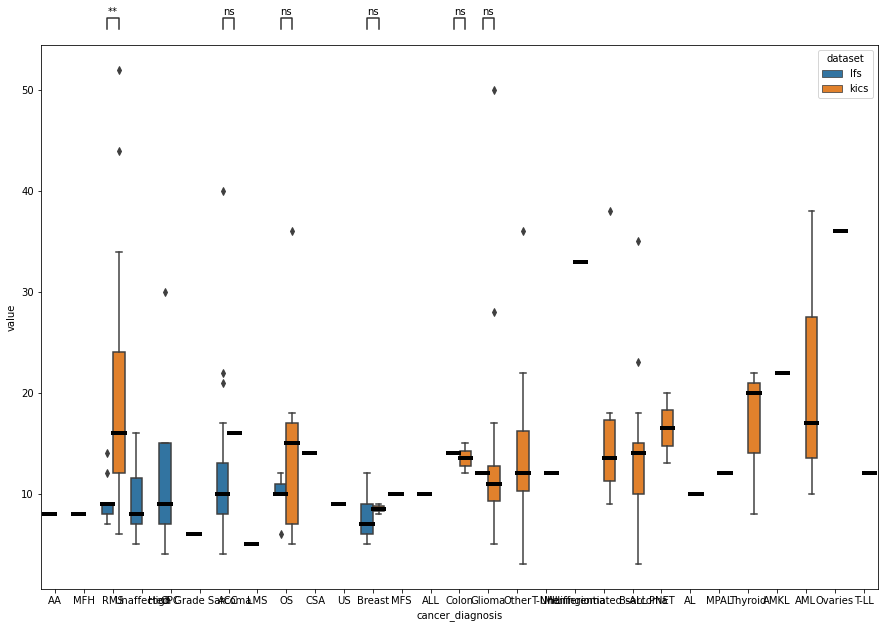

In [35]:
graphSVTissue(kDup, lDup, uniqueDiag, False)


## INV

    tissue_type variable  value dataset
0       Adrenal     freq      4     lfs
1   Soft Tissue     freq      5     lfs
2   Soft Tissue     freq      3     lfs
3    Unaffected     freq      2     lfs
4           CNS     freq      5     lfs
5    Unaffected     freq      1     lfs
6   Soft Tissue     freq      6     lfs
7   Soft Tissue     freq      4     lfs
8   Soft Tissue     freq      4     lfs
9   Soft Tissue     freq      3     lfs
10      Adrenal     freq      6     lfs
11   Unaffected     freq      6     lfs
12   Unaffected     freq      2     lfs
13  Soft Tissue     freq      7     lfs
14   Unaffected     freq      8     lfs
15   Unaffected     freq      2     lfs
16      Adrenal     freq      4     lfs
17      Adrenal     freq      1     lfs
18          CNS     freq      3     lfs
19   Unaffected     freq      1     lfs
20      Adrenal     freq      4     lfs
21  Soft Tissue     freq      2     lfs
22   Unaffected     freq      3     lfs
23      Adrenal     freq      2     lfs


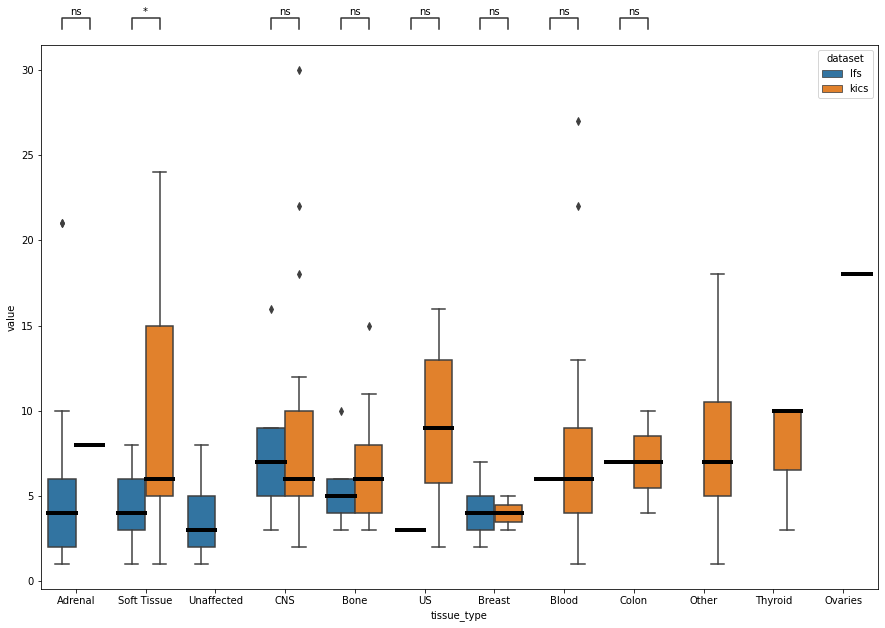

In [36]:
graphSVTissue(kInv, lInv, uniqueTissue, True)

      cancer_diagnosis variable  value dataset
0                   AA     freq      4     lfs
1                  MFH     freq      5     lfs
2                  RMS     freq      3     lfs
3           Unaffected     freq      2     lfs
4                  CPC     freq      5     lfs
5           Unaffected     freq      1     lfs
6   High Grade Sarcoma     freq      6     lfs
7                  RMS     freq      4     lfs
8                  RMS     freq      4     lfs
9                  RMS     freq      3     lfs
10                 ACC     freq      6     lfs
11          Unaffected     freq      6     lfs
12          Unaffected     freq      2     lfs
13                 LMS     freq      7     lfs
14          Unaffected     freq      8     lfs
15          Unaffected     freq      2     lfs
16                 ACC     freq      4     lfs
17                 ACC     freq      1     lfs
18                 CPC     freq      3     lfs
19          Unaffected     freq      1     lfs
20           

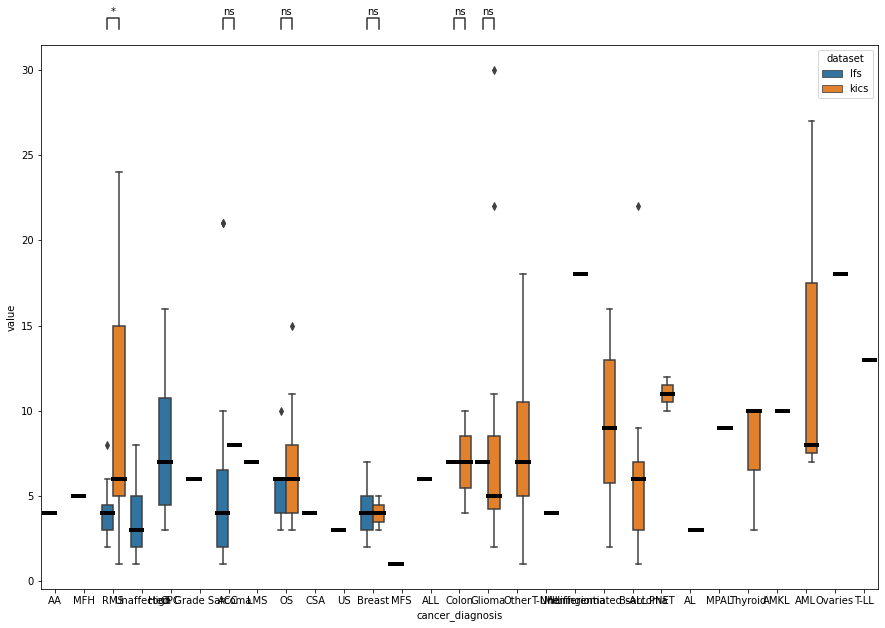

In [37]:
graphSVTissue(kInv, lInv, uniqueDiag, False)


In [38]:
"""
rare variants first >done
LFS vs Kics for Diagnosis type >done 
hypothesis tests
LFS vs unaffected
"""



'\nrare variants first >done\nLFS vs Kics for Diagnosis type >done \nhypothesis tests\nLFS vs unaffected\n'

In [39]:
"""
LFS vs Unaffected 
Types of graphs:
"""

print(bigLDf['cancer_diagnosis'].unique())

['Breast' 'ACC' 'RMS' 'AA' 'MFH' 'Unaffected' 'ALL' 'OS' 'US' 'Glioma'
 'CSA' 'High Grade Sarcoma' 'LMS' 'CPC' 'Colon' 'MFS']
